Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


Start simulation:

In [2]:
from src.simulation import ProteinSinthesisProcess

In [3]:
SIM_TIME = 3600*2
NUMBER_RESOURCES = 5
NUMBER_RNA_POLYMERASES = 3
NUMBER_RIBOSOMES = 2
URACIL_INITIAL_AMOUNT = 50000 #TODO: scegliere ordine di grandezza che venga salvato correttamente
ADENINE_INITIAL_AMOUNT = 50000
GUANINE_INITIAL_AMOUNT = 50000
CYTOSINE_INITIAL_AMOUNT = 50000
RANDOM_SEED = 42

protein_synthesis_process = ProteinSinthesisProcess(
    dna_sequences_df=data_df,
    number_resources=NUMBER_RESOURCES,
    number_rna_polymerases=NUMBER_RNA_POLYMERASES, 
    number_ribosomes=NUMBER_RIBOSOMES,
    uracil_initial_amount=URACIL_INITIAL_AMOUNT,
    adenine_initial_amount=ADENINE_INITIAL_AMOUNT,
    guanine_initial_amount=GUANINE_INITIAL_AMOUNT,
    cytosine_initial_amount=CYTOSINE_INITIAL_AMOUNT,
    random_seed=RANDOM_SEED,
    verbose=False
    )

Simulation environment initialized


In [4]:
print(protein_synthesis_process)

Protein Sinthesis Process:
185310 dna sequences to synthesize,
5 resources available,
3 RNA polymerases,
2 ribosomes.


In [5]:
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation started
End simulation: 150 proteins synthesized.


In [6]:
protein_synthesis_process.save_process() # save the process

Process saved.


Results:

In [13]:
import pandas as pd
results_path = 'results/results.csv'

results_df = pd.read_csv(results_path)

In [14]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 54
Number of DNA sequence not traslated: 46


In [15]:
results_df.columns

Index(['Unnamed: 0', 'ID', 'category', 'end_process_time',
       'end_translation_time', 'lenght_proteins', 'mrna_sequences',
       'number_different_proteins', 'number_of_proteins_synthesized',
       'polypeptides_chains', 'polypeptides_chains_ext', 'protein_synthesized',
       'request_start_process_time', 'sequence', 'start_process_time',
       'start_transcription_time', 'start_translation_time'],
      dtype='object')

In [16]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized', 'lenght_proteins', 'number_different_proteins']]

,polypeptides_chains,number_of_proteins_synthesized,lenght_proteins,number_different_proteins
0,['NH2-S-COOH'],1,[1],1.0
2,['NH2-TEDPGPRSPPPAALAPRLLAPGRSRPLKRGPPWPRCAPAC...,1,[54],1.0
7,['NH2-HKTVSLLGLRARIKGGRTSKALLDLRSLDIVGETGKTKRV...,6,"[71, 99, 99, 99, 99, 99]",2.0
9,"['NH2-EPRLLVTPHISP-COOH', 'NH2-EPSLLVTPHISP-CO...",2,"[12, 12]",2.0
10,['NH2-QIVRLLLVGTQSYETTSIFPEVVRPHSLVEVPVRPVLVSV...,5,"[42, 42, 42, 42, 42]",1.0
15,['NH2-PSSRGPLLVRSLKRSVQYNGRLRRDFEGHRTSDTCSPYQT...,2,"[57, 57]",1.0
19,"['NH2-IDAKTR-COOH', 'NH2-IDAKTR-COOH', 'NH2-ID...",4,"[6, 6, 6, 6]",1.0
20,['NH2-TGKTTPKGPNTHPHSSWYSRQRQNGVLSKRLVASPDQGVV...,2,"[40, 40]",2.0
22,['NH2-PRSALLASAPGAAAGSRSRRRPRCQGVRRVGPSAGPARGR...,1,[161],1.0
24,['NH2-PSV-COOH'],1,[3],1.0


Plot results

In [ ]:
from src.utils.plot_utils import barplot_proteins_number, plot_cumulative_proteins_number_over_time, plot_proteins_number_over_time

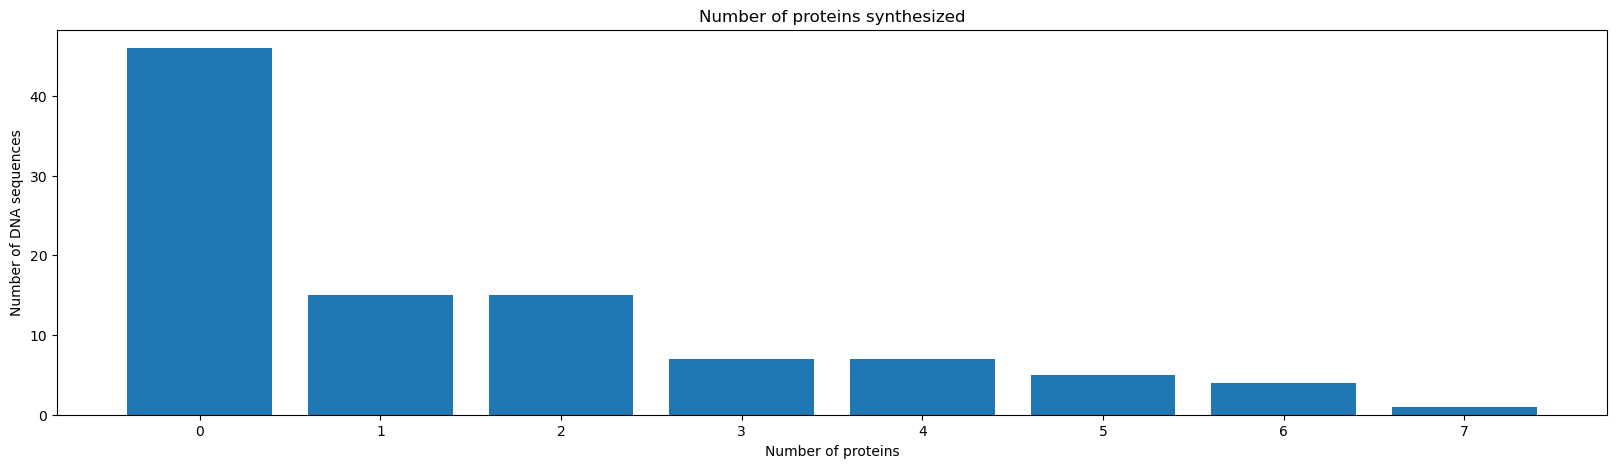

In [ ]:
barplot_proteins_number(results_df)

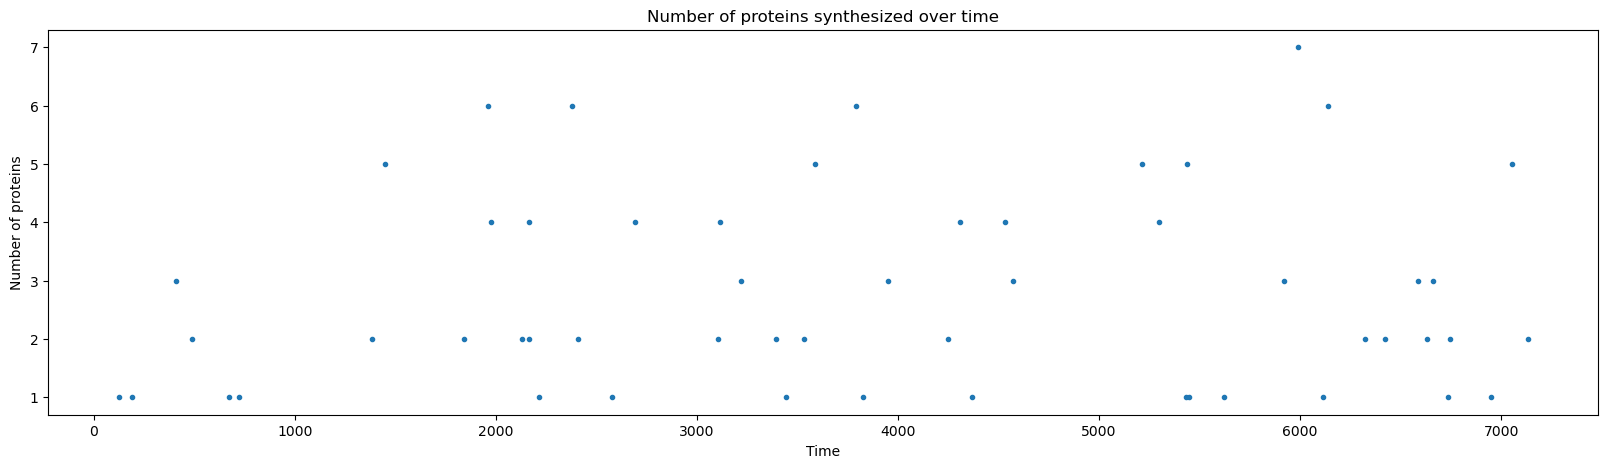

In [ ]:
plot_proteins_number_over_time(results_df)

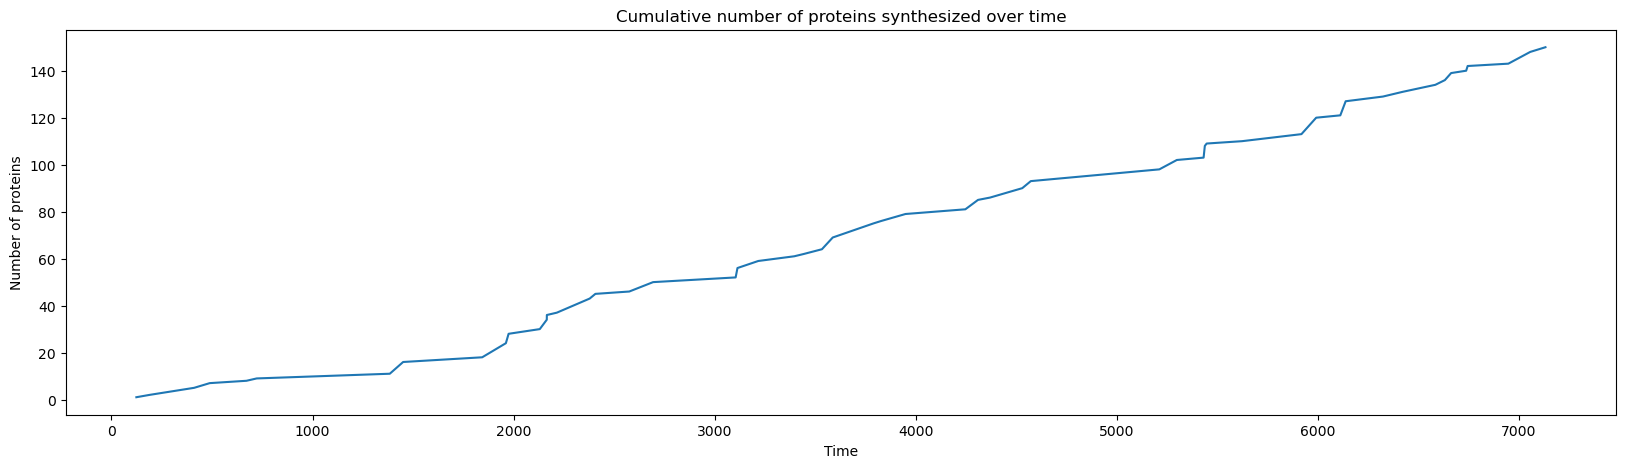

In [ ]:
plot_cumulative_proteins_number_over_time(results_df)